
<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Three: Classifier training and performance assessment. </h2>	

In [1]:
from datainput import *
from preprocess import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
train_path = './20_categories_training/'
# val_path = './20_Validation/'
# try not to printout train_data['Pictures'] directly, takes a while
train_data = read_train_data(train_path)
# test_data = read_test_data(val_path)

In [3]:
def train_test_split(df):
    """Split data into training and testing(validation)"""
    n, d = df.shape
    shuffled = np.arange(n)
    np.random.shuffle(shuffled)
    train_n = int(n*0.8)
    test_n = n-train_n
    train_idx = shuffled[:train_n]
    test_idx = shuffled[train_n:]
    return df.iloc[train_idx,:d-1], df.iloc[train_idx,d-1], df.iloc[test_idx,:d-1], df.iloc[test_idx,d-1]
    
def accuracy(pred, actual):
    return np.sum(pred==actual)/len(pred)
# Calculate the accuracy percentage of the predicted values

In [4]:
df_X = feature_frame(train_data)

Trim all images..
Processing.. image size
Processing.. aspect ratio
Processing.. red-channel average
Processing.. green-channel average
Processing.. blue-channel average
Processing.. red-channel variance
Processing.. green-channel variance
Processing.. blue-channel variance
Processing.. laplacian average
Processing.. laplacian variance
Processing.. red-channel quantiles
Processing.. green-channel quantiles
Processing.. blue-channel quantiles
Processing.. laplacian quantiles


In [11]:
# split train_data into training and testing
X_train, y_train, X_test, y_test = train_test_split(df_X)

In [12]:
np.linalg.matrix_rank(X_train), X_train.shape

(53, (1200, 54))

<h3>  Train models using all of the following methods below. Be sure to drop the actual image column, and the encoding</h3>	Take note of the differences in accuracy, and methods.


In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Logistic Regression

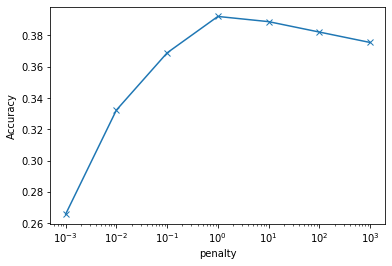

Accuracy: 0.3920265780730897


In [38]:
from sklearn.linear_model import LogisticRegression
# logistic with one over rest scheme

penalties = 10.0**np.arange(-3,4)
acc_list = np.array([0])
for c in penalties:
    logistic_model = LogisticRegression(C=c, max_iter=100, solver='liblinear', multi_class='ovr', penalty='l2')
    logistic_model.fit(X_train, y_train)
    current_acc = accuracy(logistic_model.predict(X_test),y_test)
    if current_acc > max(acc_list):
        best_model = logistic_model
    acc_list = np.r_[acc_list, current_acc]
    
plt.plot(penalties, acc_list[1:], '-x'), plt.xscale('log'), plt.xlabel('penalty'), plt.ylabel('Accuracy')
plt.show()
# logistic_model = LogisticRegression(C=0.01, max_iter=100, solver='liblinear', multi_class='ovr',random_state=9)
# logistic_model.fit(X_train, y_train)
# print('Accuracy:',accuracy(logistic_model.predict(X_test),y_test))
print('Accuracy:', max(acc_list))

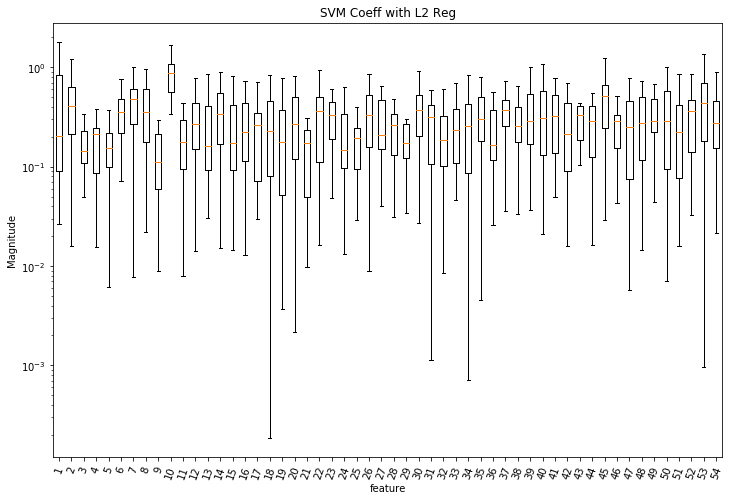

In [39]:
# visualize coefficients
coeffs = np.abs(best_model.coef_)
k, d = coeffs.shape
plt.figure(figsize=(12,8))
plt.boxplot([coeffs[:,i] for i in range(d)], showfliers=False)
plt.yscale('log'), plt.xlabel('feature'), plt.ylabel('Magnitude'), plt.title('SVM Coeff with L2 Reg')
plt.autoscale(), plt.xticks(rotation=70)
plt.show()

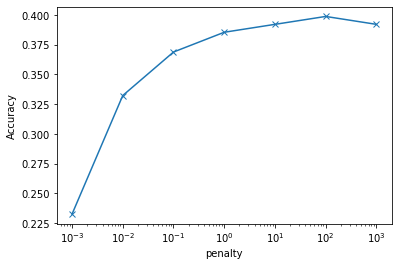

Accuracy: 0.39867109634551495


In [18]:
# multinomial logistic regression
penalties = 10.0**np.arange(-3,4)
acc_list = np.array([])
for c in penalties:
    logistic_model = LogisticRegression(C=c, max_iter=100, solver='newton-cg', multi_class='multinomial')
    logistic_model.fit(X_train, y_train)
    acc_list = np.r_[acc_list,accuracy(logistic_model.predict(X_test),y_test)]
plt.plot(penalties, acc_list, '-x'), plt.xscale('log'), plt.xlabel('penalty'), plt.ylabel('Accuracy')
plt.show()
print('Accuracy:', max(acc_list))

# logistic_model = LogisticRegression(C=0.01, max_iter=100, solver='newton-cg', multi_class='multinomial',random_state=9)
# logistic_model.fit(X_train, y_train)
# print('Accuracy:',accuracy(logistic_model.predict(X_test),y_test))

K-nearest Neighbors

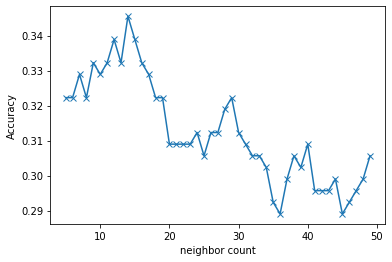

Accuracy: 0.34551495016611294


In [19]:
from sklearn.neighbors import KNeighborsClassifier
acc_list = np.array([])
neighbors = np.arange(5,50)
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors= i, weights='distance', leaf_size=30)
    knn.fit(X_train,y_train)
    acc_list = np.r_[acc_list,accuracy(knn.predict(X_test),y_test)]

plt.plot(neighbors, acc_list, '-x'), plt.xlabel('neighbor count'), plt.ylabel('Accuracy')
plt.show()
print('Accuracy:', max(acc_list))

# knn = KNeighborsClassifier(n_neighbors= 3, weights='distance', leaf_size=30)
# knn.fit(X_train,y_train)
# print('Accuracy:',accuracy(knn.predict(X_test),y_test))

Classification Tree

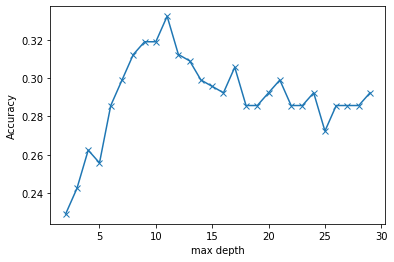

Accuracy: 0.33222591362126247


In [20]:
from sklearn.tree import DecisionTreeClassifier
    
acc_list = np.array([])
depths = np.arange(2,30)
for depth in depths:
    tree_model = DecisionTreeClassifier(max_depth=depth)
    tree_model.fit(X_train, y_train)
    acc_list = np.r_[acc_list,accuracy(tree_model.predict(X_test),y_test)]

plt.plot(depths, acc_list, '-x'), plt.xlabel('max depth'), plt.ylabel('Accuracy')
plt.show()

print("Accuracy:",max(acc_list))

Random Forest

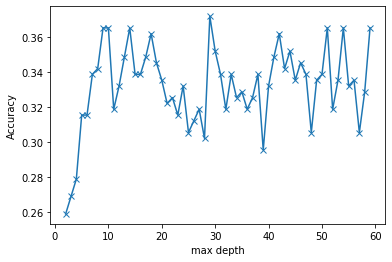

Accuracy: 0.37209302325581395


In [21]:
from sklearn.ensemble import RandomForestClassifier
    
acc_list = np.array([])
depths = np.arange(2,60)
for depth in depths:
    forest_model = RandomForestClassifier(max_depth=depth, n_estimators=10)
    forest_model.fit(X_train, y_train)
    acc_list = np.r_[acc_list,accuracy(forest_model.predict(X_test),y_test)]

plt.plot(depths, acc_list, '-x'), plt.xlabel('max depth'), plt.ylabel('Accuracy')
plt.show()

print("Accuracy:",max(acc_list))

Support Vector Machine

/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


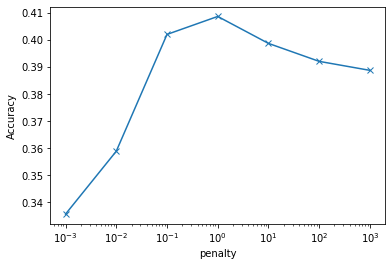

Accuracy: 0.40863787375415284


In [40]:
from sklearn.svm import LinearSVC

penalties = 10.0**np.arange(-3,4)
acc_list = np.array([0])
for c in penalties:
    svm_model = LinearSVC(C=c, dual=False, max_iter=2000)
    svm_model.fit(X_train, y_train)
    current_acc = accuracy(svm_model.predict(X_test),y_test)
    if current_acc > max(acc_list):
        best_model = svm_model
    acc_list = np.r_[acc_list, current_acc]
    
plt.plot(penalties, acc_list[1:], '-x'), plt.xscale('log'), plt.xlabel('penalty'), plt.ylabel('Accuracy')
plt.show()
print('Accuracy:', max(acc_list))

# svm_model = LinearSVC(dual=False)
# svm_model.fit(X_train, y_train)
# print('Accuracy:', accuracy(svm_model.predict(X_test),y_test))

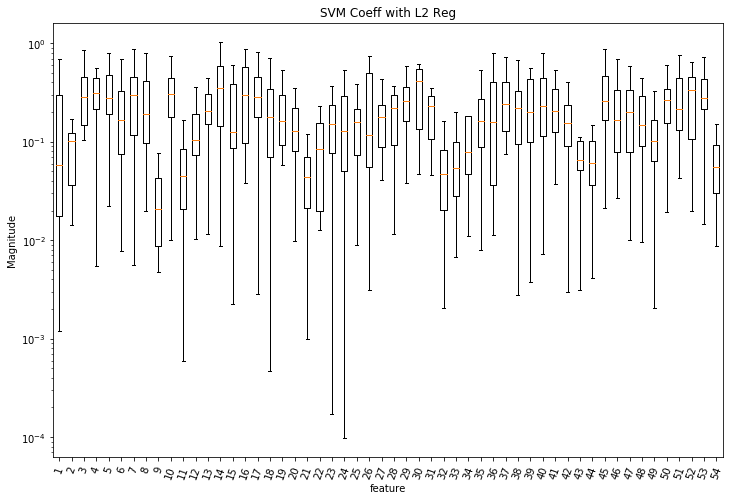

In [41]:
coeffs = np.abs(best_model.coef_)
k, d = coeffs.shape
# x = np.arange(d)
# plt.figure(figsize=(10,8))
# for i in range(k):
#     plt.scatter(x, coeffs[i,:], alpha=0.8)
# plt.plot(x, np.mean(coeffs, axis=0), lw = 2, c = 'r', label = 'Average')
# plt.legend(), plt.xlabel('feature'), plt.ylabel('Magnitude')
# plt.yscale('log'), plt.ylim(5e-10,1e-1)
# plt.show()
plt.figure(figsize=(12,8))
plt.boxplot([coeffs[:,i] for i in range(d)], showfliers=False)
plt.yscale('log'), plt.xlabel('feature'), plt.ylabel('Magnitude'), plt.title('SVM Coeff with L2 Reg')
plt.autoscale(), plt.xticks(rotation=70)
plt.show()